In [31]:
import os
import time 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import tensorflow as tf
import random
from sklearn.metrics import r2_score 

In [32]:
def setup_seed(seed):
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    return seed

randomseed = setup_seed(9807)

In [33]:
path = r'/Users/qinxusen/Desktop/Computational-Materials-II/toy_alloy_data.csv'
dr = pd.read_csv(path)
dr

,element 1,element 2,element 3,element 4,element 5,element 6,element 7,element 8,element 9,element 10,element 11,element 12,property 1,property 2,property 3,property 4,property 5,property 6
0,0.693551,0.199083,0.055558,0.032409,0.009260,0.009260,0.000324,0.000278,0.000278,0.000000,0.000000,0.000000,-0.057956,0.631224,0.759085,0.398851,-0.003600,1.342950
1,0.009337,0.000000,0.009337,0.308123,0.000000,0.659197,0.000000,0.000000,0.000000,0.009337,0.004669,0.000000,-0.108256,-0.568080,-0.247029,-0.930688,0.022768,-1.207390
2,0.956573,0.009781,0.008803,0.000000,0.016628,0.000978,0.000196,0.006847,0.000196,0.000000,0.000000,0.000000,-0.108256,1.212918,0.834180,1.341958,0.025821,-1.207390
3,0.301588,0.253547,0.013345,0.400338,0.017793,0.006672,0.000000,0.001245,0.000133,0.000000,0.000000,0.005338,-0.108256,-0.079635,0.564589,-0.625701,0.022053,1.718000
4,0.946832,0.000000,0.008616,0.037207,0.004406,0.000000,0.000343,0.002252,0.000343,0.000000,0.000000,0.000000,-0.055302,1.188204,0.831790,1.275488,-0.086048,0.592850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4607,0.004012,0.000000,0.000000,0.006018,0.002006,0.980943,0.000000,0.000000,0.000000,0.000000,0.005015,0.002006,-0.108256,-1.101748,-0.444308,-0.925376,0.022795,0.517840
4608,0.002485,0.000000,0.000298,0.000000,0.001988,0.000398,0.000000,0.000000,0.000000,0.000398,0.000298,0.994135,-0.108256,-1.133863,-0.556152,-0.925453,0.022797,-0.869845
4609,0.000484,0.000000,0.000000,0.000000,0.000000,0.677310,0.000000,0.000000,0.000000,0.319303,0.002903,0.000000,-0.108256,-0.606697,-0.938327,-0.931055,0.022789,2.993170
4610,0.697464,0.209334,0.057091,0.018079,0.009515,0.007612,0.000381,0.000381,0.000143,0.000000,0.000000,0.000000,-0.054936,0.633919,0.760399,0.413347,-0.005406,1.192930


In [34]:
count = 0
for column in dr.columns:
    count = 0
    for s in dr[column]:
        if s==0:
            count+=1
            
    print("%s 列中为0的数据 %d 个, 占该列总数的 %.2f%%" % (column, count, count/dr.shape[0]*100))

element 1 列中为0的数据 302 个, 占该列总数的 6.55%
element 2 列中为0的数据 1979 个, 占该列总数的 42.91%
element 3 列中为0的数据 841 个, 占该列总数的 18.24%
element 4 列中为0的数据 2644 个, 占该列总数的 57.33%
element 5 列中为0的数据 993 个, 占该列总数的 21.53%
element 6 列中为0的数据 1393 个, 占该列总数的 30.20%
element 7 列中为0的数据 1992 个, 占该列总数的 43.19%
element 8 列中为0的数据 2251 个, 占该列总数的 48.81%
element 9 列中为0的数据 2222 个, 占该列总数的 48.18%
element 10 列中为0的数据 2715 个, 占该列总数的 58.87%
element 11 列中为0的数据 2550 个, 占该列总数的 55.29%
element 12 列中为0的数据 2812 个, 占该列总数的 60.97%
property 1 列中为0的数据 0 个, 占该列总数的 0.00%
property 2 列中为0的数据 0 个, 占该列总数的 0.00%
property 3 列中为0的数据 0 个, 占该列总数的 0.00%
property 4 列中为0的数据 0 个, 占该列总数的 0.00%
property 5 列中为0的数据 0 个, 占该列总数的 0.00%
property 6 列中为0的数据 0 个, 占该列总数的 0.00%


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = dr.iloc[:, :12].to_numpy()
Y = dr.iloc[:, 12:].to_numpy()

X_data = StandardScaler().fit_transform(X)
Y_data = StandardScaler().fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                    test_size=0.2,
                                                    random_state=randomseed)

# DNN

In [36]:
torchX = torch.tensor(X, dtype=torch.float)
torchY = torch.tensor(Y, dtype=torch.float)
torchX_train = torch.tensor(X_train, dtype=torch.float)
torchX_test = torch.tensor(X_test, dtype=torch.float)
torchY_train = torch.tensor(Y_train, dtype=torch.float)
torchY_test = torch.tensor(Y_test, dtype=torch.float)

In [37]:
def DNNmodel(n):
    model = nn.Sequential(
        nn.Linear(12, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, n)
    )
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    return optimizer, model


mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1


The accuracy of Challange 1 from DNN in PyTorch is: 0.7779794169434845
Time used by DNN Regression of Challange 1 in PyTorch with training 3000 times is 0m 13s


Text(0.5, 0, 'Accuracy of each step')

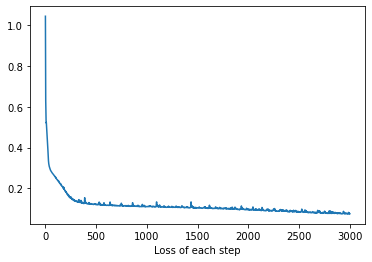

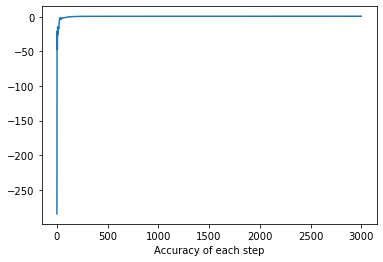

In [42]:
since = time.time()

optimizer_DNN_cha1, model_DNN_cha1 = DNNmodel(Y_train.shape[1])

train_steps = 3000
loss = np.zeros(train_steps, dtype=float)
acc = np.zeros(train_steps, dtype=float)
for step in range(train_steps):
    pre = model_DNN_cha1(torchX_train)
    mse = mse_loss(pre, torchY_train)
    acc_perstep = r2_score(pre.detach().numpy(),torchY_train)
    kl = kl_loss(model_DNN_cha1)
    cost = mse
    loss[step] = cost
    acc[step] = acc_perstep
    optimizer_DNN_cha1.zero_grad()
    cost.backward()
    optimizer_DNN_cha1.step()
    

from sklearn.metrics import r2_score 

Y_DNN_predict = model_DNN_cha1(torchX_test)

accuracy_DNN_cha1 = r2_score(Y_DNN_predict.detach().numpy(),Y_test)


print("The accuracy of Challange 1 from DNN in PyTorch is:", accuracy_DNN_cha1)


time_elapsed = time.time() - since
print('Time used by DNN Regression of Challange 1 in PyTorch with training {:.0f} times is {:.0f}m {:.0f}s'.format(train_steps, 
    time_elapsed // 60, time_elapsed % 60))


plt.figure()
plt.plot(np.linspace(1, train_steps, train_steps), loss)
plt.xlabel('Loss of each step')

plt.figure()
plt.plot(np.linspace(1, train_steps, train_steps), acc)
plt.xlabel('Accuracy of each step')


In [43]:
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D


def DNN_model(n):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, input_shape=(12, ), activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(n, activation='relu'),
    ])
    # model.summary()

    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

In [44]:
tftorchX = tf.convert_to_tensor(X, dtype=tf.float32)
tftorchY = tf.convert_to_tensor(Y, dtype=tf.float32)
tftorchX_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
tftorchX_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
tftorchY_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
tftorchY_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

2022-05-06 23:37:32.468549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The accuracy of Challange 1 from DNN in Tensorflow is: -0.9734694251722237
Time used by DNN Regression in Tensorflow of Challange 1 with training 3000 times is 2m 58s


2022-05-06 23:40:30.687202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


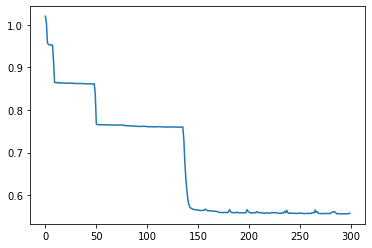

In [45]:
since = time.time()

model = DNN_model(Y_train.shape[1])
history = model.fit(tftorchX_train, tftorchY_train,
                    epochs=300, verbose=0)
plt.plot(history.epoch, history.history.get('loss'), label='loss')
pre = model.predict(tftorchX_test)
accuracy = r2_score(pre, tftorchY_test)

print("The accuracy of Challange 1 from DNN in Keras is:", accuracy)


time_elapsed = time.time() - since
print('Time used by DNN Regression in Keras of Challange 1 with training {:.0f} times is {:.0f}m {:.0f}s'.format(train_steps,
                                                                                                                      time_elapsed // 60, time_elapsed % 60))


# Gaussian Regression


The accuracy of Challenge one from GPR is: -1.0439050960818772
Time used by GPR of Challenge 1 is 1m 25s


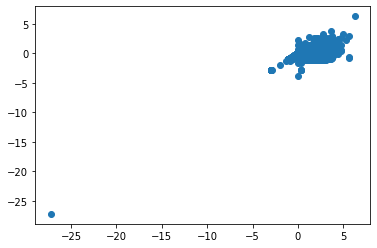

In [56]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

since = time.time()

kernel = ConstantKernel(constant_value=2, constant_value_bounds=(
    1, 1e4)) + RBF(length_scale=10, length_scale_bounds=(1e-4, 1e4))

reg = GaussianProcessRegressor(kernel=kernel, random_state=randomseed)

reg.fit(X_train, Y_train)

pred = reg.predict(X_test)


plt.scatter(pred, Y_test)

accuracy_GPR_cha1 = r2_score(pred, Y_test)
print("The accuracy of Challenge one from GPR is:", accuracy_GPR_cha1)


time_elapsed = time.time() - since
print('Time used by GPR of Challenge 1 is {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))


# Random Forest Regressor

The accuracy of Challenge one from GPR is: 0.6743192385581387
Time used by Random Forest Regressor of Challenge 1 is 0m 3s


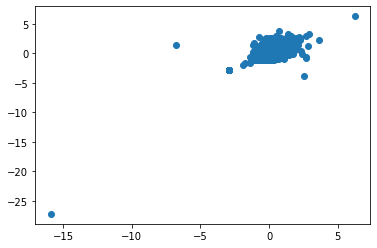

In [58]:
from sklearn.ensemble import RandomForestRegressor

since = time.time()

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

accuracy_GPR_cha1 = r2_score(Y_pred, Y_test)
print("The accuracy of Random Forest Regressor from GPR is:", accuracy_GPR_cha1)

plt.scatter(Y_pred, Y_test)

time_elapsed = time.time() - since
print('Time used by Random Forest Regressor of Challenge 1 is {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# BNN

In [46]:
def BNNmodel(n):
    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                        in_features=12, out_features=100),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                        in_features=100, out_features=100),
        # nn.ReLU(),
        # bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
        #                 in_features=100, out_features=100),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                        in_features=100, out_features=n),
    )
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    return optimizer, model


mse_loss = nn.MSELoss()

kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)


kl_weight = 0.1


The accuracy of Challange 1 from BNN is: 0.7028832999411373
Time used by BNN Regression of Challange 1 with training 3000 times is 0m 15s


Text(0.5, 0, 'Accuracy of each step')

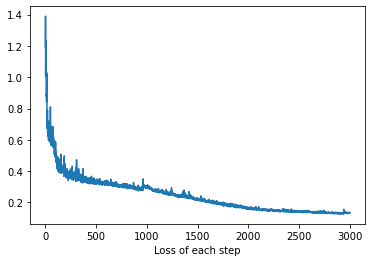

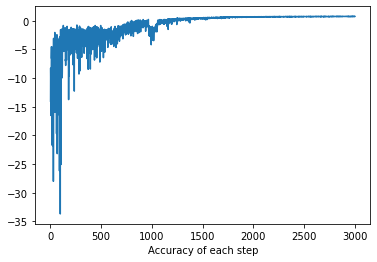

In [59]:
since = time.time()

optimizer_cha1, model_cha1 = BNNmodel(Y_train.shape[1])

train_steps = 3000
loss = np.zeros(train_steps, dtype=float)
acc = np.zeros(train_steps, dtype=float)
for step in range(train_steps):
    pre = model_cha1(torchX_train)
    mse = mse_loss(pre, torchY_train)
    acc_perstep = r2_score(pre.detach().numpy(),torchY_train)
    kl = kl_loss(model_cha1)
    cost = mse
    loss[step] = cost
    acc[step] = acc_perstep
    optimizer_cha1.zero_grad()
    cost.backward()
    optimizer_cha1.step()
    

from sklearn.metrics import r2_score 

Y_BNN_predict = model_cha1(torchX_test)

accuracy_BNN_cha1 = r2_score(Y_BNN_predict.detach().numpy(),Y_test)


print("The accuracy of Challange 1 from BNN is:", accuracy_BNN_cha1)


time_elapsed = time.time() - since
print('Time used by BNN Regression of Challange 1 with training {:.0f} times is {:.0f}m {:.0f}s'.format(train_steps, 
    time_elapsed // 60, time_elapsed % 60))


plt.figure()
plt.plot(np.linspace(1, train_steps, train_steps), loss)
plt.xlabel('Loss of each step')

plt.figure()
plt.plot(np.linspace(1, train_steps, train_steps), acc)
plt.xlabel('Accuracy of each step')


# Sparse GPRegression

In [61]:
import GPy

def create_kernel():
    return GPy.kern.Matern52(lengthscale=1, input_dim=12, variance=1, ARD=True)

The accuracy of Challenge one from SGPR is: -0.8707924991117588
Time used by SGPR of Challenge 1 is 0m 1s


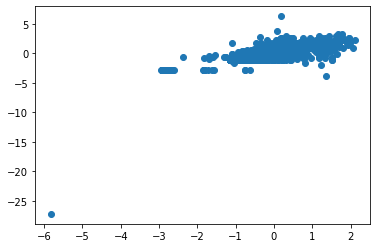

In [64]:
since = time.time()

sgpr_cha1 = GPy.models.SparseGPRegression(X_train, Y_train,
                                          num_inducing=900,
                                          kernel=create_kernel())


mu_cha1, cov_cha1 = sgpr_cha1.predict(X_test)
accuracy_SGPR_cha1 = r2_score(mu_cha1, Y_test)


plt.scatter(mu_cha1, Y_test)
print("The accuracy of Challenge one from SGPR is:", accuracy_SGPR_cha1)


time_elapsed = time.time() - since
print('Time used by SGPR of Challenge 1 is {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
